# Inspect Rich Documents with Gemini Multimodality and Multimodal RAG Challenge Lab

__Note__: if you encounter an authentication error when running the cells in the notebook, go to __Vertex AI__ > __Dashboard__, and click on __Enable All Recommended APIs__. Then, re-run the failed cell, and continue the lab.  

## Setup and requirements

### Install Vertex AI SDK for Python and other dependencies

Run the following four cells below before you get to Task 1. Be sure to add your current project ID to the cell titled __Define Google Cloud project information__. 

In [1]:
# "RUN THIS CELL AS IS"

# Install required python packages and other dependencies
!pip3 install --upgrade --user google-cloud-aiplatform

!pip3 install --upgrade --user google-cloud-aiplatform pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 62.2 MB/s eta 0:00:00:00:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 61.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 82.7 MB/s eta 0:00:00:00:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Restart current runtime

You must restart the runtime in order to use the newly installed packages in this Jupyter runtime. You can do this by running the cell below, which will restart the current kernel.


In [2]:
# "RUN THIS CELL AS IS"

import IPython

# Restart the kernet after libraries are loaded.

app = IPython.Application.instance()
app.kernel.do_shutdown(True)


{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Define Google Cloud project information

In [1]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

import sys

# Define project information and update the location if it differs from the one specified in the lab instructions.
PROJECT_ID = "qwiklabs-gcp-00-e68c7e254b99"  # @param {type:"string"}
LOCATION = "us-east4"  # @param {type:"string"}

# Try to get the PROJECT_ID automatically.
if "google.colab" not in sys.modules:
    import subprocess

    PROJECT_ID = subprocess.check_output(
        ["gcloud", "config", "get-value", "project"], text=True
    ).strip()

print(f"Your project ID is: {PROJECT_ID}")


Your project ID is: qwiklabs-gcp-00-e68c7e254b99


### Initialize Vertex AI

Initialize the Vertex AI SDK for Python for your project:

In [2]:
# "RUN THIS CELL AS IS"

# Initialize Vertex AI.
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)


## Task 1. Generating Multimodal Insights with the Gemini Pro Vision model

Gemini 1.0 Pro Vision (gemini-1.0-pro-vision) is a multimodal model that supports multimodal prompts. You can include text, image(s), and video in your prompt requests and get text or code responses.

To complete Task 1, follow the instructions at the top of each notebook cell:
* Run the cells with the comment "RUN THIS CELL AS IS".
* Complete and run the cells with the comment "COMPLETE THE MISSING PART AND RUN THIS CELL".

__Note__: Ensure you can see the weather related data in the response that is printed.


### Setup and requirements for Task 1

#### Import libraries

In [3]:
# "RUN THIS CELL AS IS"

from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)

#### Load Gemini 1.0 Pro Vision model

In [4]:
# "RUN THIS CELL AS IS"

multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

#### Define helper functions

In [5]:
# "RUN THIS CELL AS IS"

import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_images([content])
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_multimodal_prompt(contents: list[str | Image | Part]):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)

### Task 1.1. Image understanding across multiple images

In [7]:
# "RUN THIS CELL AS IS"

# You're going to work with provided variables in this task. 
# First, review and describe the content/purpose of each variable below. 

image_ask_first_1_url = "https://storage.googleapis.com/spls/gsp520/Google_Branding/Ask_first_1.png"
image_dont_do_this_1_url = "https://storage.googleapis.com/spls/gsp520/Google_Branding/Dont_do_this_1.png"
image_ask_first_1 = load_image_from_url(image_ask_first_1_url)
image_dont_do_this_1 = load_image_from_url(image_dont_do_this_1_url)

instructions = "Instructions: Consider the following image that contains text:"
prompt1 = "What is the title of this image"
prompt2 = """
Answer the question through these steps:
Step 1: Identify the title of each image by using the filename of each image.
Step 2: Describe the image.
Step 3: For each image, describe the actions that a user is expected to take.
Step 4: Extract the text from each image as a full sentence.
Step 5: Describe the sentiment for each image with an explanation.

Answer and describe the steps taken:
"""

#### Create an input for the multimodal model

In [16]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to create an input for your multimodal model. Create your contents list using the variables above. Ensure the structure matches the format expected by the multimodal model.

contents = [
    image_ask_first_1,  # image1
    prompt1,            # prompt1
    image_dont_do_this_1,  # image2
    prompt2,            # prompt2
    instructions        # image3 (although instructions is text, it fits as the last element)
]



#### Generate responses from the multimodal model

In [17]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the next part of this task, you're going to generate responses from the multimodal model. Capture the output of the model in the "responses" variable by using your "contents" list.


responses = multimodal_model.generate_content(contents)

#### Display the prompt and responses


### Prompts ###



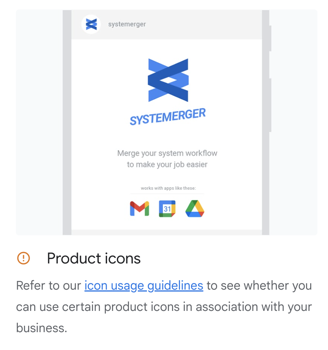

What is the title of this image


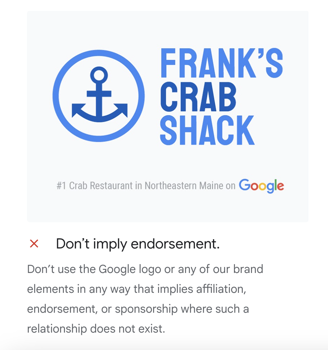


Answer the question through these steps:
Step 1: Identify the title of each image by using the filename of each image.
Step 2: Describe the image.
Step 3: For each image, describe the actions that a user is expected to take.
Step 4: Extract the text from each image as a full sentence.
Step 5: Describe the sentiment for each image with an explanation.

Answer and describe the steps taken:

Instructions: Consider the following image that contains text:
### Model Responses ###

 Image 1
Title: Systemerger
Description: The image is a screenshot of a web page. The page has a blue background with a white logo in the center. The logo is a stylized letter "S" with the word "Systemerger" written below it. The text "Merge your system workflow to make your job easier" appears below the logo. There are three app icons below the text. The icons are for Gmail, Google Calendar, and Google Drive.
Expected actions: The user is expected to read the text and click on one of the app icons.
Text: "Systeme

In [21]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the last part of this task, you're going to print your contents and responses with the prompt and responses title provided. Use descriptive titles to help organize the output (e.g., "Prompts", "Model Responses") and then display the prompt and responses by using the print() function. 

# Hint: "\n" inserts a newline character for clearer separation between the sections.


# Print the contents with descriptive titles
print("### Prompts ###\n")

print_multimodal_prompt(contents)

print("### Model Responses ###\n")

# Printing the responses (the images would typically be handled differently, but they are referenced here)
print(responses.text)


### To verify your work for Task 1.1, click __Check my progress__ in the lab instructions.

### Task 1.2. Similarity/Differences between images

#### Explore the variables of the task

In [23]:
# "RUN THIS CELL AS IS"

# You're going to work with provided variables in this task. First, review and describe the content/purpose of each variable below. 


image_ask_first_3_url = "https://storage.googleapis.com/spls/gsp520/Google_Branding/Ask_first_3.png"
image_dont_do_this_3_url =  "https://storage.googleapis.com/spls/gsp520/Google_Branding/Dont_do_this_3.png"
image_ask_first_3 = load_image_from_url(image_ask_first_3_url)
image_dont_do_this_3 = load_image_from_url(image_dont_do_this_3_url)

prompt1 = """
Consider the following two images:
Image 1:
"""
prompt2 = """
Image 2:
"""
prompt3 = """
1. What is shown in Image 1 and Image 2?
2. What is similar between the two images?
3. What is difference between Image 1 and Image 2 in terms of the text ?
"""



#### Create an input for the multimodal model

In [24]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to create an input for your multimodal model. Create your contents list using the variables above. Ensure the structure matches the format expected by the multimodal model.

# Prepare contents
contents = [image_ask_first_3, prompt1, image_dont_do_this_3, prompt2, prompt3]

#### Set configuration parameters

In [28]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to set configuration parameters that will influence how the multimodal model generates text. These settings control aspects like the creativity and focus of the responses. Here's how:
# Temperature: Controls randomness. Lower values mean more predictable results, higher values mean more surprising and creative outpu
# Top p / Top k: Affects how the model chooses words. Explore different values to see how they change the results.
# Other parameters: Check the model's documentation for additional options you might want to adjust.

# Store your configuration parameters in a generation_config variable. This improves reusability, allowing you to easily apply the same settings across tasks and make adjustments as needed.

generation_config = {
    'temperature': 0.7,  # Adjust for creativity
    'top_p': 0.9,        # Control randomness in word selection
    'top_k': 40,         # Limit choices to the top k words
    # Add any other relevant parameters as needed
}



#### Generate responses from the multimodal model


In [29]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the next part of this task, you're going to generate responses from a multimodal model. capture the output of the model in the "responses" variable by using your "contents" list and the confiuguration settings.


responses = multimodal_model.generate_content(contents,generation_config=generation_config)


#### Display the prompt and responses

In [34]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the last part of this task, you're going to print your contents and responses with the prompt and responses title provided. Use descriptive titles to help organize the output (e.g., "Prompts", "Model Responses") and then display the prompt and responses by using the print() function. 

# Hint: "\n" inserts a newline character for clearer separation between the sections.

# Print contents and responses with titles
print("Prompts:")
print(prompt1)
print(image_ask_first_3)  # Assuming you have a way to display the image
print(prompt2)
print(image_dont_do_this_3)  # Assuming you have a way to display the image
print(prompt3)

print("\nModel Responses:")
print(responses)


Prompts:

Consider the following two images:
Image 1:


Image 2:


1. What is shown in Image 1 and Image 2?
2. What is similar between the two images?
3. What is difference between Image 1 and Image 2 in terms of the text ?


Model Responses:
candidates {
  finish_reason: RECITATION
  safety_ratings {
    category: HARM_CATEGORY_HATE_SPEECH
    probability: NEGLIGIBLE
    probability_score: 0.1767578125
    severity: HARM_SEVERITY_NEGLIGIBLE
    severity_score: 0.10986328125
  }
  safety_ratings {
    category: HARM_CATEGORY_DANGEROUS_CONTENT
    probability: NEGLIGIBLE
    probability_score: 0.1748046875
    severity: HARM_SEVERITY_NEGLIGIBLE
    severity_score: 0.134765625
  }
  safety_ratings {
    category: HARM_CATEGORY_HARASSMENT
    probability: NEGLIGIBLE
    probability_score: 0.21875
    severity: HARM_SEVERITY_NEGLIGIBLE
    severity_score: 0.12890625
  }
  safety_ratings {
    category: HARM_CATEGORY_SEXUALLY_EXPLICIT
    probability: NEGLIGIBLE
    probability_score: 0.096

### To verify your work for Task 1.2, click __Check my progress__ in the lab instructions.

### Task 1.3. Generate a video description

#### Explore the variables of the task


In [38]:
# "RUN THIS CELL AS IS"

# You're going to work with provided variables in this task. 
# First, review and describe the content/purpose of each variable below. 


prompt = """
What is the product shown in this video?
What specific product features are highlighted in the video?
Where was this video filmed? Which cities around the world could potentially serve as the background in the video?
What is the sentiment of the video?
"""
video = Part.from_uri(
    uri="gs://spls/gsp520/google-pixel-8-pro.mp4",
    mime_type="video/mp4",
)

#### Create an input for the multimodal model

In [39]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to create an input for your multimodal model. Create your contents list using the variables above. Ensure the structure matches the format expected by the multimodal model.

contents = [prompt, video]

#### Generate responses from the multimodal model

In [40]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the next part of this task, you're going to generate responses from a multimodal model. Capture the output of the model in the "responses" variable by using your "contents" list.


responses = multimodal_model.generate_content(contents)


#### Display the prompt and responses

**Note:** If you encounter any authentication error below cell run, go to the **Navigation menu**, click **Vertex AI > Dashboard**, then click **"Enable all Recommended APIs"** Now, go back to cell 16, and run cells 16, 17 and below cell.

In [41]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the last part of this task, you're going to print your contents and responses with the prompt and responses title provided. Use descriptive titles to help organize the output (e.g., "Prompts", "Model Responses") and then display the prompt and responses by using the print() function. 

# Hint: "\n" inserts a newline character for clearer separation between the sections.

print("Prompts:\n", prompt)
print("\nContents:\n", contents)
print("\nModel Responses:\n", responses)


Prompts:
 
What is the product shown in this video?
What specific product features are highlighted in the video?
Where was this video filmed? Which cities around the world could potentially serve as the background in the video?
What is the sentiment of the video?


Contents:
 ['\nWhat is the product shown in this video?\nWhat specific product features are highlighted in the video?\nWhere was this video filmed? Which cities around the world could potentially serve as the background in the video?\nWhat is the sentiment of the video?\n', file_data {
  mime_type: "video/mp4"
  file_uri: "gs://spls/gsp520/google-pixel-8-pro.mp4"
}
]

Model Responses:
 candidates {
  content {
    role: "model"
    parts {
      text: " The product shown in this video is the Google Pixel 8 Pro.\n\nThe specific product features highlighted in the video are:\n\n* The phone\342\200\231s AI capabilities, which are showcased through various features such as the ability to automatically edit photos and videos, and

Proceed to Task 1.4 below (no progress check for Task 1.3 in lab instructions). 

### Task 1.4. Extract tags of objects throughout the video

#### Explore the variables of the task

In [51]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# You're going to work with provided variables in this task. First, review and describe the content/purpose of each variable below. 

prompt = """
Answer the following questions using the video only:

Which particular sport is highlighted in the video?
What values or beliefs does the advertisement communicate about the brand?
What emotions or feelings does the advertisement evoke in the audience?
Which tags associated with objects featured throughout the video could be extracted?
"""
video = Part.from_uri(
    uri="gs://spls/gsp520/google-pixel-8-pro.mp4",
    mime_type="video/mp4",
)

#### Create an input for the multimodal model

In [52]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to create an input for your multimodal model. Create your contents list using the variables above. Ensure the structure matches the format expected by the multimodal model.

contents = [prompt, video]

#### Generate responses from the multimodal model

In [53]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the next part of this task, you're going to generate responses from a multimodal model. capture the output of the model in the "responses" variable by using your "contents" list and video input.


responses = multimodal_model.generate_content(contents)

#### Display the prompt and responses

In [54]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the last part of this task, you're going to print your contents and responses with the prompt and responses title provided. Use descriptive titles to help organize the output (e.g., "Prompts", "Model Responses") and then display the prompt and responses by using the print() function. 

# Hint: "\n" inserts a newline character for clearer separation between the sections.

print("Prompts:\n", prompt)
print("\nContents:\n", contents)
print("\nModel Responses:\n", responses)

Prompts:
 
Answer the following questions using the video only:

Which particular sport is highlighted in the video?
What values or beliefs does the advertisement communicate about the brand?
What emotions or feelings does the advertisement evoke in the audience?
Which tags associated with objects featured throughout the video could be extracted?


Contents:
 ['\nAnswer the following questions using the video only:\n\nWhich particular sport is highlighted in the video?\nWhat values or beliefs does the advertisement communicate about the brand?\nWhat emotions or feelings does the advertisement evoke in the audience?\nWhich tags associated with objects featured throughout the video could be extracted?\n', file_data {
  mime_type: "video/mp4"
  file_uri: "gs://spls/gsp520/google-pixel-8-pro.mp4"
}
]

Model Responses:
 candidates {
  content {
    role: "model"
    parts {
      text: " - Basketball\n- The advertisement communicates that the Google Pixel 8 Pro is a powerful and versatile s

Proceed to Task 1.5 below (no progress check for Task 1.4 in lab instructions). 

### Task 1.5. Ask more questions about a video

**Note:** Although this video contains audio, Gemini does not currently support audio input and will only answer based on the video.

#### Explore the variables of the task

In [55]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# You're going to work with provided variables in this task. 
# First, review and describe the content/purpose of each variable below. 


prompt = """
Answer the following questions using the video only:

How does the advertisement portray the use of technology, specifically AI, in capturing and preserving memories?
What visual cues or storytelling elements contribute to the nostalgic atmosphere of the advertisement?
How does the advertisement depict the role of friendship and social connections in enhancing experiences and creating memories?
Are there any specific features or functionalities of the phone highlighted in the advertisement, besides its AI capabilities?

Provide the answer JSON.
"""
video = Part.from_uri(
    uri="gs://spls/gsp520/google-pixel-8-pro.mp4",
    mime_type="video/mp4",
)


#### Create an input for the multimodal model

In [56]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to create an input for your multimodal model. Create your contents list using the variables above. Ensure the structure matches the format expected by the multimodal model.

contents = [prompt, video]

#### Generate responses from the multimodal model

In [57]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the next part of this task, you're going to generate responses from a multimodal model. capture the output of the model in the "responses" variable by using your "contents" list and video input.


responses = multimodal_model.generate_content(contents)

#### Display the prompt and responses

In [58]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the last part of this task, you're going to print your contents and responses with the prompt and responses title provided. Use descriptive titles to help organize the output (e.g., "Prompts", "Model Responses") and then display the prompt and responses by using the print() function. 

# Hint: "\n" inserts a newline character for clearer separation between the sections.

print("Prompts:\n", prompt)
print("\nContents:\n", contents)
print("\nModel Responses:\n", responses)

Prompts:
 
Answer the following questions using the video only:

How does the advertisement portray the use of technology, specifically AI, in capturing and preserving memories?
What visual cues or storytelling elements contribute to the nostalgic atmosphere of the advertisement?
How does the advertisement depict the role of friendship and social connections in enhancing experiences and creating memories?
Are there any specific features or functionalities of the phone highlighted in the advertisement, besides its AI capabilities?

Provide the answer JSON.


Contents:
 ['\nAnswer the following questions using the video only:\n\nHow does the advertisement portray the use of technology, specifically AI, in capturing and preserving memories?\nWhat visual cues or storytelling elements contribute to the nostalgic atmosphere of the advertisement?\nHow does the advertisement depict the role of friendship and social connections in enhancing experiences and creating memories?\nAre there any spec

Proceed to Task 1.6 below (no progress check for Task 1.5 in lab instructions). 

### Task 1.6. Retrieve extra information beyond the video

#### Explore the variables of the task

In [59]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# You're going to work with provided variables in this task. 
# First, review and describe the content/purpose of each variable below. 


prompt = """
Answer the following questions using the video only:

How does the advertisement appeal to its target audience through its messaging and imagery?
What overall message or takeaway does the advertisement convey about the brand and its products?
Are there any symbolic elements or motifs used throughout the advertisement to reinforce its central themes?
What is the best hashtag for this video based on the description ?

"""
video = Part.from_uri(
    uri="gs://spls/gsp520/google-pixel-8-pro.mp4",
    mime_type="video/mp4",
)

#### Create an input for the multimodal model

In [60]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to create an input for your multimodal model. Create your contents list using the variables above. Ensure the structure matches the format expected by the multimodal model.

contents = [prompt, video]

#### Generate responses from the multimodal model

In [61]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the next part of this task, you're going to generate responses from a multimodal model. capture the output of the model in the "responses" variable by using your "contents" list and video input.


responses = multimodal_model.generate_content(contents)

#### Display the prompt and responses

In [62]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the last part of this task, you're going to print your contents and responses with the prompt and responses title provided. Use descriptive titles to help organize the output (e.g., "Prompts", "Model Responses") and then display the prompt and responses by using the print() function. 

# Hint: "\n" inserts a newline character for clearer separation between the sections.

print("Prompts:\n", prompt)
print("\nContents:\n", contents)
print("\nModel Responses:\n", responses)

Prompts:
 
Answer the following questions using the video only:

How does the advertisement appeal to its target audience through its messaging and imagery?
What overall message or takeaway does the advertisement convey about the brand and its products?
Are there any symbolic elements or motifs used throughout the advertisement to reinforce its central themes?
What is the best hashtag for this video based on the description ?



Contents:
 ['\nAnswer the following questions using the video only:\n\nHow does the advertisement appeal to its target audience through its messaging and imagery?\nWhat overall message or takeaway does the advertisement convey about the brand and its products?\nAre there any symbolic elements or motifs used throughout the advertisement to reinforce its central themes?\nWhat is the best hashtag for this video based on the description ?\n\n', file_data {
  mime_type: "video/mp4"
  file_uri: "gs://spls/gsp520/google-pixel-8-pro.mp4"
}
]

Model Responses:
 candidat

### To verify your work for Task 1.6, click __Check my progress__ in the lab instructions.

## Task 2. Retrieving and integrating knowledge with multimodal retrieval augmented generation (RAG)

To complete Task 2, follow the instructions at the top of each notebook cell:
* Run the cells with the comment "RUN THIS CELL AS IS".
* Complete and run the cells with the comment "COMPLETE THE MISSING PART AND RUN THIS CELL".

For additional information about the available data and helper functions for Task 2, review the section named __Available data and helper functions for Task 2__ in the lab instructions.

### Setup and requirements for Task 2

#### Import libraries

In [63]:
# "RUN THIS CELL AS IS"

# Import necessary packages and libraries.

from IPython.display import Markdown, display
from vertexai.generative_models import (
    Content,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Image,
    Part,
)


#### Load the Gemini 1.0 Pro and Gemini 1.0 Pro Vision model

In [64]:
# "RUN THIS CELL AS IS"

# Load the Gemini 1.0 Pro and Gemini 1.0 Pro Vision model.

text_model = GenerativeModel("gemini-1.0-pro")
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

#### Download custom Python modules and utilities 

The cell below will download some helper functions needed for this notebook, to improve readability. You can also view the code (`intro_multimodal_rag_utils.py`) directly on [Github](https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/intro_multimodal_rag_utils.py).

In [65]:
# "RUN THIS CELL AS IS"

# Import necessary packages and libraries.
import os
import urllib.request
import sys

if not os.path.exists("utils"):
    os.makedirs("utils")


# Download the helper scripts from utils folder.
url_prefix = "https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/"
files = ["intro_multimodal_rag_utils.py"]

for fname in files:
    urllib.request.urlretrieve(f"{url_prefix}/{fname}", filename=f"utils/{fname}")


#### Get documents and images from Cloud Storage

In [66]:
# "RUN THIS CELL AS IS"

# Download documents and images used in this notebook.

!gsutil -m rsync -r gs://spls/gsp520 .
print("Download completed")

I0000 00:00:1727094394.127149    9322 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork


Building synchronization state...
Starting synchronization...
Copying gs://spls/gsp520/Google_Branding/Ask_first_3.png...
Copying gs://spls/gsp520/Google_Branding/Ask_first_1.png...                     
Copying gs://spls/gsp520/Google_Branding/Go_for_it_1.png...                     
Copying gs://spls/gsp520/Google_Branding/.DS_Store...                           
Copying gs://spls/gsp520/Google_Branding/Ask_first_2.png...                     
Copying gs://spls/gsp520/Google_Branding/Dont_do_this_1.png...                  
Copying gs://spls/gsp520/Google_Branding/Dont_do_this_3.png...                  
Copying gs://spls/gsp520/Google_Branding/Dont_do_this_4.png...
Copying gs://spls/gsp520/Google_Branding/Dont_do_this_2.png...                  
Copying gs://spls/gsp520/Google_Branding/Dont_do_this_6.png...                  
Copying gs://spls/gsp520/Google_Branding/Go_for_it_2.png...                     
Copying gs://spls/gsp520/Google_Branding/Dont_do_this_5.png...
Copying gs://spls/gsp52

### Task 2.1. Build metadata of documents containing text and images

__Note__: These steps may take a few minutes to complete.

#### Import helper functions to build metadata

In [98]:
# "RUN THIS CELL AS IS"

# Import helper functions from utils.
from utils.intro_multimodal_rag_utils import get_document_metadata

#### Explore the variables of the task

In [118]:
# "RUN THIS CELL AS IS"

# You're going to work with provided variables in this task. 
# First, review and describe the content/purpose of each variable below. 


# Specify the "PDF folder path" with single PDF and "PDF folder" with multiple PDF.

pdf_folder_path = "Google_Branding/"  # if running in Vertex AI Workbench.

# Specify the image description prompt. Change it
image_description_prompt = """Describe the content of the image.
If it features a table, summarize its contents.
If it includes a graph, interpret the key findings.
Avoid using any numbers not shown in the image.
"""


#### Extract and store metadata of text and images from a document

In [119]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Call the "get_document_metadata" function from the utils file to extract text and image metadata from the PDF document. Store the results in two different DataFrames: "text_metadata_df" and "image_metadata_df".  
# text_metadata_df: This will contain extracted text snippets, their corresponding page numbers, and potentially other relevant information.
# image_metadata_df: This will contain descriptions of the images found in the PDF (if any), along with their location within the document.
image_save_dir ="Google_Branding/"
text_metadata_df, image_metadata_df = get_document_metadata(pdf_folder_path, image_save_dir, image_description_prompt)

print("\n\n --- Completed processing. ---")

TypeError: get_document_metadata() missing 1 required positional argument: 'image_description_prompt'

#### Inspect the processed text metadata

In [101]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Explore the text_metadata_df dataframe by displaying the first few rows of the dataframe.

"ENTER YOUR CODE HERE"

'ENTER YOUR CODE HERE'

#### Import the helper functions to implement RAG

In [102]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Import helper functions from utils.

# Import helper functions from utils.
from utils.intro_multimodal_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    get_similar_image_from_query,
    print_text_to_image_citation,
    get_gemini_response,
    display_images,
)


Proceed to Task 2.2 below (no progress check for Task 2.1 in lab instructions). 

### Task 2.2. Create a user query

#### Explore the variables of the task

In [103]:
# "RUN THIS CELL AS IS"

# You're going to work with provided variables in this task. 
# First, review and describe the content/purpose of each variable below. 

query = """Questions:
 - What are the key expectations that users can have from Google regarding the provision and development of its services?
- What specific rules and guidelines are established for users when using Google services?
- How does Google handle intellectual property rights related to the content found within its services, including content owned by users, Google, and third parties? 
- What legal rights and remedies are available to users in case of problems or disagreements with Google?
- How do the service-specific additional terms interact with these general Terms of Service, and which terms take precedence in case of any conflicts?
 """

Proceed to Task 2.3 below (no progress check for Task 2.2 in lab instructions).

### Task 2.3. Get all relevant text chunks

#### Retrieve relevant chunks of text based on the query

In [104]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Call the "get_similar_text_from_query" function from the utils file to retrieve relevant chunks of text based on the query. Store the results in a dictionart called "matching_results_chunks_data".  
# matching_results_chunks_data: This dictionary will contain file_name, page_num, cosine_score, chunk_number and chunk_socre. The dictionary represents a search result for a query related to the text_metadata_df.

# Call the "get_similar_text_from_query" function from the utils file to retrieve relevant chunks of text based on the query.
matching_results_chunks_data = get_similar_text_from_query(query, text_metadata_df)  # Adjust parameters if needed


NameError: name 'text_metadata_df' is not defined

#### Display the first item of the text chunk dictionary

In [105]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Explore the first item in your matching_results_chunks_data dictionary by displaying the first item.

"ENTER YOUR CODE HERE"

'ENTER YOUR CODE HERE'

Proceed to Task 2.4 below (no progress check for Task 2.3 in lab instructions).

### Task 2.4. Create context_text

#### Create a list to store the combined chunks of text

In [106]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"


# Create an empty list named "context_text". This list will be used to store the combined chunks of text.
context_text = []


#### Iterate through each item in the text chunks dictionary

In [107]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Create a for loop to iterate through each item in the matching_results_chunks_data dictionary in order to combine all the selected relevant text chunks

# Create a for loop to iterate through each item in the matching_results_chunks_data dictionary
for chunk in matching_results_chunks_data:
    # Append the relevant text chunk to the context_text list
    context_text.append(matching_results_chunks_data[chunk])



NameError: name 'matching_results_chunks_data' is not defined

#### Join all the text chunks and store in a list

In [108]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Take all of the individual text chunks stored in the context_text list and join them together into a single string named final_context_text. Use "\n" part inserts a newline character between each chunk, effectively creating separate lines or paragraphs.

final_context_text = "ENTER YOUR CODE HERE"

Proceed to Task 2.5 below (no progress check for Task 2.4 in lab instructions).

### Task 2.5. Pass context to Gemini

#### Explore the variables of the task


In [109]:
# "RUN THIS CELL AS IS"

# You're going to work with provided variables in this task. First, review and describe the content/purpose of each variable below. 

prompt = f""" Instructions: Compare the images and the text provided as Context: to answer multiple Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.
If unsure, respond, "Not enough context to answer".

Context:
 - Text Context:
 {final_context_text}


{query}

Answer:
"""

#### Generate Gemini response with streaming output

In [110]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Call "get_gemini_response" function from utils module in order to generate Gemini response with streaming output. This function uses a multimodal Gemini model, a text prompt, and configuration parameters and instructs the Gemini model to generate a response using the provided prompt. As Gemini model enables streaming, you will receive chunks of the response as they were produced. 
# Format the streamed output using Markdown syntax for easy readability and conversion to HTML.

"ENTER YOUR CODE HERE"

'ENTER YOUR CODE HERE'

### To verify your work for Task 2.5, click __Check my progress__ in the lab instructions.